# Text mining project - SEC 8-K for Stock Price Forecasting

## Import & preprocessing

In [1]:
# Disable jedi to make autocompletion much faster
%config Completer.use_jedi = False

First, we import the data, which comes with adjusted ppc (price percent change) into a dataframe

In [404]:
from parse_file import foo
foo()

ModuleNotFoundError: No module named 'parse_file'

In [203]:
import pandas as pd
import numpy as np
# Stock price history
alpha_df = pd.read_csv('./data/alphavantage.csv')
# S&P500 history
sp500_df = pd.read_csv('./data/sp500_hist.csv')
# SEC 8-K forms
sec8_series = pd.read_json("./data/preprocessed_sec8_filings.json")['data']
sec8_df_raw = pd.DataFrame(sec8_series.sum())
sec8_df_raw = sec8_df_raw.dropna().reset_index()
sec8_df_raw.head()

,index,ticker,cik,sec_filing_date,text,target_day1open_day1close_ppc,target_day1open_day2close_ppc,target_day1open_day3close_ppc,target_dayneg1close_day1open_ppc
0,1,AIT,109563,2017-01-13 00:00:00,0000109563-17-000018.txt : 20170113 0000109563...,-0.007612,0.011033,0.012198,0.006320
1,2,AIT,109563,2017-01-26 00:00:00,0000109563-17-000036.txt : 20170126 0000109563...,-0.026110,-0.035664,-0.051111,0.000495
2,3,AIT,109563,2017-03-02 00:00:00,0000109563-17-000062.txt : 20170302 0000109563...,-0.003292,-0.005536,-0.008944,-0.013831
3,4,AIT,109563,2017-04-27 00:00:00,0000109563-17-000074.txt : 20170427 0000109563...,-0.042239,-0.047690,-0.039190,0.044192
4,5,AIT,109563,2017-05-15 00:00:00,0000109563-17-000080.txt : 20170515 0000109563...,-0.005644,-0.024592,-0.021755,0.003241


Some of the text aren't properly fetched from the website, since the request was rejected. We remove these

In [403]:
import re
failed = []
for j in range(len(sec8_df_raw)):
    #texts_8k = extract_8k_texts(sec8_df_raw['text'][j])
    thresholdExceed = re.compile("Request Rate Threshold Exceeded", re.IGNORECASE)
    if thresholdExceed.search(sec8_df_raw['text'][j]):
        failed.append(j)
# Drop the failed rows
sec8_df_raw.drop(failed, inplace=True)

### Baseline
As a simple baseline, we use the price percent change for the previous day of the sec filing day from open to close.

In [ ]:
%%time
sp500_df.Datum = pd.to_datetime(sp500_df.Datum)
sp500_df = sp500_df.sort_values("Datum")
sp500_df.columns = ["date", "close", "volume", "open", "high", "low"]

# Go through each ticker and date for the filings, and calculate the adjusted ppc from the day before the filing
# If no data exists the day before, take the latest day
sec8_df_raw['feature_ppc_dayneg1'] = np.nan
alpha_df.date = alpha_df.date.apply(pd.to_datetime)

for index, row in sec8_df_raw.iterrows():
    ticker, date = row['ticker'], row['sec_filing_date']
    date = pd.to_datetime(date)
    # print(ticker, date)
    # Select rows where date is the day before filing
    sp500_neg1 = sp500_df[sp500_df.date < date].tail(1)
    alpha_neg1 = alpha_df[alpha_df.date < date].tail(1)
    # Only calculate ppc if dates exist on both dfs
    if sp500_neg1.date.iloc[0] == alpha_neg1.date.iloc[0]:
        sp500_ppc = (sp500_neg1.close.iloc[0]-sp500_neg1.open.iloc[0])/sp500_neg1.open.iloc[0]
        alpha_ppc = (alpha_neg1.close.iloc[0]-alpha_neg1.open.iloc[0])/alpha_neg1.open.iloc[0]
        ppc = alpha_ppc - sp500_ppc
        sec8_df_raw.loc[(sec8_df_raw.sec_filing_date == str(date)) & (sec8_df_raw.ticker == ticker), 'feature_ppc_dayneg1'] = ppc
    

Next, we need a function to convert numerical labels to categorical {"UP", "DOWN", "STAY"}

In [109]:
label_dict = {
    "DOWN": 0,
    "STAY": 1,
    "UP": 2
}
def conv_col_to_cat(df, col):
    # Converts a column in dataframe with numerical targets to categorical
    df_new = df.copy()
    df_new[col] = label_dict["STAY"]
    df_new.loc[df[col] > 0.01, col] = label_dict["UP"]
    df_new.loc[df[col] < -0.01, col] = label_dict["DOWN"]
    return df_new

Now, we create a dataframe with only the relevant information, and convert numerical targets to {"UP", "DOWN", "STAY"}

In [361]:
sec8_df = sec8_df_raw.copy()
sec8_df.drop(["index", "cik"], axis=1, inplace=True)
sec8_df = conv_col_to_cat(sec8_df, 'target_day1open_day1close_ppc')
sec8_df = conv_col_to_cat(sec8_df, 'target_day1open_day2close_ppc')
sec8_df = conv_col_to_cat(sec8_df, 'target_day1open_day3close_ppc')
sec8_df = conv_col_to_cat(sec8_df, 'target_dayneg1close_day1open_ppc')
sec8_df = conv_col_to_cat(sec8_df, 'feature_ppc_dayneg1')
sec8_df.head()

,ticker,sec_filing_date,text,target_day1open_day1close_ppc,target_day1open_day2close_ppc,target_day1open_day3close_ppc,target_dayneg1close_day1open_ppc,feature_ppc_dayneg1
0,AIT,2017-01-13 00:00:00,0000109563-17-000018.txt : 20170113 0000109563...,1,2,2,1,1
1,AIT,2017-01-26 00:00:00,0000109563-17-000036.txt : 20170126 0000109563...,0,0,0,1,1
2,AIT,2017-03-02 00:00:00,0000109563-17-000062.txt : 20170302 0000109563...,1,1,1,0,1
3,AIT,2017-04-27 00:00:00,0000109563-17-000074.txt : 20170427 0000109563...,0,0,0,2,0
4,AIT,2017-05-15 00:00:00,0000109563-17-000080.txt : 20170515 0000109563...,1,0,0,1,1


We calculate a baseline by simply using the ppc from the day before the filing as our prediction.

In [373]:
#np.bincount(sec8_df.target_day1open_day3close_ppc)
#print(classification_report(sec8_df.target_day1open_day1close_ppc, sec8_df.feature_ppc_dayneg1))
print(classification_report(sec8_df.target_day1open_day1close_ppc, np.zeros([len(sec8_df)]))) # sec8_df.feature_ppc_dayneg1))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56      7053
           1       0.00      0.00      0.00      4903
           2       0.00      0.00      0.00      6358

    accuracy                           0.39     18314
   macro avg       0.13      0.33      0.19     18314
weighted avg       0.15      0.39      0.21     18314



/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cleaning

Let's take a look at a filing:

In [400]:
sec8_df_raw['text'][101]

'0000002178-18-000065.txt : 20181107 0000002178-18-000065.hdr.sgml : 20181107 20181107161940 ACCESSION NUMBER: 0000002178-18-000065 CONFORMED SUBMISSION TYPE: 8-K PUBLIC DOCUMENT COUNT: 3 CONFORMED PERIOD OF REPORT: 20181107 ITEM INFORMATION: Results of Operations and Financial Condition ITEM INFORMATION: Financial Statements and Exhibits FILED AS OF DATE: 20181107 DATE AS OF CHANGE: 20181107 FILER: COMPANY DATA: COMPANY CONFORMED NAME: ADAMS RESOURCES & ENERGY, INC. CENTRAL INDEX KEY: 0000002178 STANDARD INDUSTRIAL CLASSIFICATION: WHOLESALE-PETROLEUM & PETROLEUM PRODUCTS (NO BULK STATIONS) [5172] IRS NUMBER: 741753147 STATE OF INCORPORATION: DE FISCAL YEAR END: 1231 FILING VALUES: FORM TYPE: 8-K SEC ACT: 1934 Act SEC FILE NUMBER: 001-07908 FILM NUMBER: 181166611 BUSINESS ADDRESS: STREET 1: 17 S. BRIAR HOLLOW LN. CITY: HOUSTON STATE: TX ZIP: 77027 BUSINESS PHONE: 713-881-3600 MAIL ADDRESS: STREET 1: P O BOX 844 CITY: HOUSTON STATE: TX ZIP: 77001 FORMER COMPANY: FORMER CONFORMED NAME: A

Let's clean up the text a bit - we lemmatize, remove numeric values, and remove any 1 letter words.
Also, we assume that the most important text is in the beginning, so we truncate each text to 1000 words.

In [52]:
import spacy
nlp = spacy.load('en_core_web_lg', disable='parser')
MAX_SEQ_LEN = 2000

def preprocess(text):
    if len(text.split()) > MAX_SEQ_LEN*2:
        text = ' '.join(text.split()[:MAX_SEQ_LEN*2])
    processed = [token.lemma_ for token in nlp(text) if token.lemma_.isalpha() and len(token.lemma_) > 1]
    if len(processed) > MAX_SEQ_LEN:
        return ' '.join(processed[:MAX_SEQ_LEN])
    return ' '.join(processed)

## SHELF
#from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer(tokenizer=preprocess)
#X = vectorizer.fit_transform(sec8_df['text'].head(100))

CPU times: user 1.31 s, sys: 773 ms, total: 2.09 s
Wall time: 2.12 s


In [54]:
%%time
sec8_demo = sec8_df.copy().head(50)
sec8_demo['text'] = sec8_demo['text'].apply(preprocess) 

CPU times: user 19.5 s, sys: 2.05 s, total: 21.5 s
Wall time: 21.6 s


Preprocess all data:

In [55]:
%%time
df = sec8_df.copy().head(5000)
df['text'] = df['text'].apply(preprocess)
df.to_csv("data/processed_df.csv")

CPU times: user 33min 40s, sys: 3min 59s, total: 37min 40s
Wall time: 37min 45s


In [376]:
df.loc[0, 'text']

'ACCESSION number conformed submission type PUBLIC document count conformed PERIOD of REPORT item information departure of director or Certain Officers Election of Directors Appointment of certain Officers Compensatory Arrangements of Certain Officers file AS of date date AS of change FILER COMPANY DATA company conformed name APPLIED INDUSTRIAL TECHNOLOGIES INC CENTRAL INDEX key STANDARD INDUSTRIAL CLASSIFICATION WHOLESALE MACHINERY EQUIPMENT SUPPLIES IRS number state of INCORPORATION oh fiscal year END filing value form type SEC ACT Act SEC file number film number business address STREET one apply PLAZA CITY CLEVELAND STATE OH zip business PHONE MAIL address STREET one apply PLAZA CITY CLEVELAND STATE OH zip former COMPANY former conformed name BEARINGS INC DATE of name change former COMPANY former conformed name BROWN JIM STORES INC DATE of name change Document UNITED STATES SECURITIES and EXCHANGE COMMISSION Washington FORM CURRENT report PURSUANT to section or of the SECURITIES EXC

Let's use the Tokenizer from keras to represent each word as an index. We only want to learn the word index from the training data.

In [160]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

sec8_demo = df.copy()
X = sec8_demo['text']
y = sec8_demo.iloc[:, 3:]
y.columns = ['n0', 'n1', 'n2', 'n3']
# Split train/test/val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tokenizer = Tokenizer()
# Fit tokenizer to training texts
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
VOCAB_SIZE = len(tokenizer.word_index)

# Convert texts to index sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# Pad the sequences
X_train = pad_sequences(X_train, maxlen=2000, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=2000, padding="post", truncating="post")

Let's see what we have to work with:

In [191]:
inverse_word_index = {word_index[key]: key for key in word_index.keys()}
inverse_word_index[0] = "<>"

'accession number conformed submission type public document count conformed period of report item information other event item information financial statements and exhibit file as of date date as of change filer company data company conformed name freeport mcmoran inc central index key standard industrial classification metal mining irs number state of incorporation de fiscal year end filing value form type sec act act sec file number film number business address street north central avenue city phoenix state az zip business phone mail address street north central avenue city phoenix state az zip former company former conformed name freeport mcmoran copper gold inc date of name change former company former conformed name freeport mcmoran copper company inc date of name change document united states securities and exchange commission washington form current report pursuant to section or of the securities exchange act of date of report date of early event report march freeport mcmoran ex

In [161]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3500, 2000)
(3500, 4)
(1500, 2000)
(1500, 4)


So our input features are all of dimension 2000 and we have 4 target variables.

Class distribution:

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


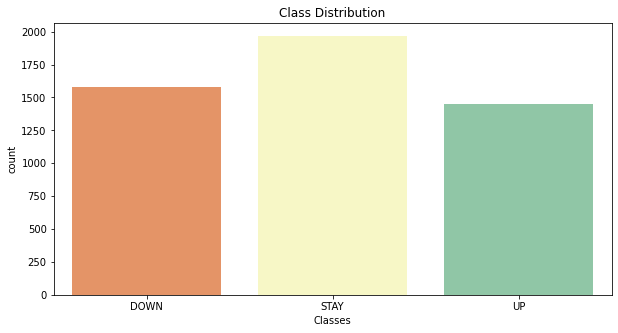

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot class distribution
plt.figure(figsize=(10, 5))
sns.countplot(y.n0, palette='Spectral')
plt.xlabel('Classes')
plt.xticks([label_dict["DOWN"], label_dict["STAY"], label_dict["UP"]], ["DOWN", "STAY", "UP"])
plt.title('Class Distribution');

## Baseline

In [168]:
# Todo
from sklearn.dummy import DummyClassifier

model_majority = DummyClassifier(strategy="prior")
model_uni = DummyClassifier(strategy="uniform")

model_majority.fit(X_train, y_train.n0)
model_uni.fit(X_train, y_train.n0)

y_pred_majority = model_majority.predict(X_test)
y_pred_uni = model_uni.predict(X_test)

In [172]:
print("## Majority classifier")
print(classification_report(y_test.n0, y_pred_majority))

print("## Random classifier")
print(classification_report(y_test.n0, y_pred_uni))

## Majority classifier
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       507
           1       0.37      1.00      0.54       552
           2       0.00      0.00      0.00       441

    accuracy                           0.37      1500
   macro avg       0.12      0.33      0.18      1500
weighted avg       0.14      0.37      0.20      1500

## Random classifier
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       507
           1       0.39      0.33      0.36       552
           2       0.32      0.38      0.35       441

    accuracy                           0.35      1500
   macro avg       0.35      0.35      0.35      1500
weighted avg       0.35      0.35      0.35      1500



/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Pretraining the embedding layer

In our model, we use an embedding layer as the first layer, both in order to reduce the dimension of our vocabulary, and to give meaningful vector representations of our words (compared to using unique integers or one-hot encoding). What we mean by "meaningful" in this context is that if there is some relationship between words, this should be reflected in the vectors in space. For example, two vectors embedding similar words could be nearby in space.

We will use the GloVe word embeddings, to avoid having to train the weights of the embedding layer ourselves and hopefully achieve better performance.

In [68]:
%%time
import os
# Pretrain the embedding layer using GloVe
# Code for building embedding matrix from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
GLOVE_DIR = './data/glove.6B'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

EMBEDDING_DIM = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
oov_list = []

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        oov_list.append(word)

Found 400000 word vectors.
CPU times: user 10.5 s, sys: 258 ms, total: 10.7 s
Wall time: 10.7 s


Words in the filings that are out-of-vocabulary, i.e. not in GloVe are printed below. 

(From a quick inspection, these do not seem important for the classification task anyway!)

## Creating the neural network
Let's create the deep neural network model which uses as the first layer the embedding layer we just created

In [139]:
from tensorflow import keras
from tensorflow.keras import layers
layers.Embedding
model = keras.models.Sequential()
model.add(layers.Embedding(input_dim=VOCAB_SIZE+1, 
                           output_dim=EMBEDDING_DIM, 
                           input_length=MAX_SEQ_LEN,
                           weights=[embedding_matrix],
                           trainable=False))

model.add(layers.LSTM(32, dropout=0.25))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 2000, 100)         1959100   
                                                                 
 lstm_4 (LSTM)               (None, 32)                17024     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,976,157
Trainable params: 1,976,157
Non-trainable params: 0
_________________________________________________________________


In [173]:
# Train the model

loss = keras.losses.CategoricalCrossentropy()
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)
model.fit(X_train, y_train.n0, epochs=1, verbose=2)

110/110 - 77s - loss: 0.0000e+00 - accuracy: 0.3374 - 77s/epoch - 699ms/step


## Prediction

In [177]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
def float_to_label(p):
    if p < 0.5: 
        return 0
    elif p > 1.5:
        return 2
    return 1
y_pred = [[float_to_label(p) for p in row] for row in y_pred]
y_pred

[[0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0],
 [0]

In [179]:
print(classification_report(y_test.n0, y_pred))

              precision    recall  f1-score   support

           0       0.34      1.00      0.51       507
           1       0.56      0.01      0.02       552
           2       0.00      0.00      0.00       441

    accuracy                           0.34      1500
   macro avg       0.30      0.34      0.17      1500
weighted avg       0.32      0.34      0.18      1500



/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Emil/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
